[Collab](https://colab.research.google.com/drive/1d9l2-NXW5traKPQ0j-l4eZ2vSI0mEVvV)

# ⛹⛹⛹⛹⛹⛹⛹⛹

**=================================================**

Breakline

# Using One Hot and Tokenizer 🉐


> **Up-To-Date ✔**




---



# Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder


# Load Dataset

In [ ]:
# Load Event dataset
event_data = pd.read_csv("./events_dataset.csv",usecols=['Event_id','Category','Location','Qualifications'])
event_df = pd.DataFrame(event_data,)

# Load User dataset
user_data = pd.read_csv("./users_data_interest.csv",usecols=['Volunteer Name','Skills','Location','Type of Organization','Interest'])
# user_data = pd.read_csv("./test.csv",usecols=['Volunteer Name','Skills','Location','Type of Organization','Interest'])
user_df = pd.DataFrame(user_data)

# G Variabel

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

# Split Dataset

In [ ]:
# Split event and user data into training and testing sets
event_train, event_test = train_test_split(event_df, test_size=0.2, random_state=42)
user_train, user_test = train_test_split(user_df, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(user_df['Interest'], test_size=0.2, random_state=42)


# Tokenizer

In [ ]:
# Tokenizer Train and Test Qualifications
tokenizer_qualification = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_qualification.fit_on_texts(event_train['Qualifications'])

qualification_seq = tokenizer_qualification.texts_to_sequences(event_train['Qualifications'])
qualification_pad = pad_sequences(qualification_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

qualification_seq_test = tokenizer_qualification.texts_to_sequences(event_test['Qualifications'])
qualification_pad_test = pad_sequences(qualification_seq_test, maxlen=max_length, padding=padding_type, truncating= trunc_type)


# Tokenizer Train and Test Skill
tokenizer_skill = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_skill.fit_on_texts(user_train['Skills'])

skill_seq = tokenizer_skill.texts_to_sequences(user_train['Skills'])
skill_pad = pad_sequences(skill_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

skill_seq_test = tokenizer_skill.texts_to_sequences(user_test['Skills'])
skill_pad_test = pad_sequences(skill_seq_test, maxlen=max_length, padding=padding_type, truncating= trunc_type)

In [ ]:
word_index = tokenizer_qualification.word_index
for word, index in word_index.items():
    print(f'"{word}":{index},')



In [ ]:
import json

In [ ]:
y = json.dumps(word_index)
y

In [ ]:
with open('data.json', 'w') as f:
    json.dump(word_index, f )

# One Hot Encoding

In [ ]:
# One hot encoding Event
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
event_cat_loc_org_encoded_train = encoder.fit_transform(event_train[['Category', 'Location']])
event_cat_loc_org_encoded_test = encoder.transform(event_test[['Category', 'Location']])

# One hot encoding user
user_loc_org_encoded_train = encoder.fit_transform(user_train[['Location', 'Type of Organization']])
user_loc_org_encoded_test = encoder.transform(user_test[['Location', 'Type of Organization']])

# Bulid Model Keras

In [ ]:
# Build user model
user_NN = tf.keras.models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length),
    tf.keras.layers.LSTM(32, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # Dense(64,activation='relu'),
    Dense(64, name='user_embedding')  # output layer for user model
    # Dense(1, activation='sigmoid', name='user_embedding')
])

# Build event model
event_NN = tf.keras.models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length),
    tf.keras.layers.LSTM(32, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # Dense(64,activation='relu'),
    Dense(64, name='event_embedding')  # output layer for event model
    # Dense(1, activation='sigmoid', name='event_embedding')

])



# Set Input for `fit()`

In [ ]:
# Inputs for user and event
input_user_skills = Input(shape=(max_length,), name='input_user_skills')
input_user_loc_org = Input(shape=(user_loc_org_encoded_train.shape[1],), name='input_user_loc_org')
input_event_qualifications = Input(shape=(max_length,), name='input_event_qualifications')
input_event_cat_loc_org = Input(shape=(event_cat_loc_org_encoded_train.shape[1],), name='input_event_cat_loc_org')

In [ ]:
# Call user and event models
vu_skills = user_NN(input_user_skills)
vu_loc_org = Dense(128, activation='relu')(input_user_loc_org)
vu = Concatenate()([vu_skills, vu_loc_org])

vm_qualifications = event_NN(input_event_qualifications)
vm_cat_loc_org = Dense(128, activation='relu')(input_event_cat_loc_org)
vm = Concatenate()([vm_qualifications, vm_cat_loc_org])

combined_vu_vm = Concatenate()([vu, vm])

# Specify the inputs and outputs of the model
# model = tf.keras.Model([input_user_skills, input_user_loc_org, input_event_qualifications, input_event_cat_loc_org], [vu, vm])

# model with combined
model = Model([input_user_skills, input_user_loc_org, input_event_qualifications, input_event_cat_loc_org],combined_vu_vm)

Callbacks|

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') < 0.00005 :
            print("\nReached loss 5e-5 so stop the epoch for training!")
            self.model.stop_training = True

callback = myCallback()

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_user_skills (InputLa  [(None, 120)]                0         []                            
 yer)                                                                                             
                                                                                                  
 input_user_loc_org (InputL  [(None, 97)]                 0         []                            
 ayer)                                                                                            
                                                                                                  
 input_event_qualifications  [(None, 120)]                0         []                            
  (InputLayer)                                                                                

In [ ]:
# Define inputs and outputs for training
train_inputs = [skill_pad, user_loc_org_encoded_train, qualification_pad, event_cat_loc_org_encoded_train]

In [ ]:
history = model.fit(train_inputs, y_train, epochs=20, callbacks=callback)

Epoch 1/20
70/70 [==============================] - 1s 16ms/step - loss: 0.6859 - root_mean_squared_error: 0.8282
Epoch 2/20
70/70 [==============================] - 1s 17ms/step - loss: 0.6831 - root_mean_squared_error: 0.8265
Epoch 3/20
70/70 [==============================] - 1s 17ms/step - loss: 0.6777 - root_mean_squared_error: 0.8232
Epoch 4/20
70/70 [==============================] - 1s 12ms/step - loss: 0.6861 - root_mean_squared_error: 0.8283
Epoch 5/20
70/70 [==============================] - 1s 12ms/step - loss: 0.6811 - root_mean_squared_error: 0.8253
Epoch 6/20
70/70 [==============================] - 1s 12ms/step - loss: 0.6826 - root_mean_squared_error: 0.8262
Epoch 7/20
70/70 [==============================] - 1s 12ms/step - loss: 0.6752 - root_mean_squared_error: 0.8217
Epoch 8/20
70/70 [==============================] - 1s 12ms/step - loss: 0.6831 - root_mean_squared_error: 0.8265
Epoch 9/20
70/70 [==============================] - 1s 12ms/step - loss: 0.6776 - root_m

In [ ]:
test_inputs = [skill_pad_test, user_loc_org_encoded_test, qualification_pad_test, event_cat_loc_org_encoded_test]
model.evaluate(test_inputs, y_test)

18/18 [==============================] - 0s 8ms/step - loss: 0.7038 - root_mean_squared_error: 0.8389


[0.7038088440895081, 0.8389331698417664]

# Prediction


In [ ]:
## using the user in the test set
user_index = 0
user_input = [
    skill_pad_test[user_index][None, ...],
    user_loc_org_encoded_test[user_index][None, ...],
    qualification_pad_test[user_index][None, ...],
    event_cat_loc_org_encoded_test[user_index][None, ...],
]

Menggunakan pembobotan terhadap category event dan type of organization user

In [ ]:
# Buat prediksi dengan model Anda
user_predictions = model.predict(user_input)

# Ubah prediksi menjadi DataFrame
predictions_df = pd.DataFrame(user_predictions.flatten(), columns=['Interest_Score'])

# Gabungkan prediksi dengan data acara
results_df = pd.concat([event_test.reset_index(drop=True), predictions_df], axis=1)

# add nama pengguna dan 'Type of Organization' ke DataFrame hasil
results_df['User_Name'] = user_test.iloc[user_index]['Volunteer Name']
results_df['User_Organization_Type'] = user_test.iloc[user_index]['Type of Organization']
# kolom baru 'Interest_Score_Adjusted' yang memberikan bobot lebih tinggi
# untuk acara yang 'Category'-nya cocok dengan 'Type of Organization' pengguna
results_df['Interest_Score_Adjusted'] = np.where(results_df['Category'] == results_df['User_Organization_Type'],
                                                 results_df['Interest_Score'] * 1.002,
                                                 results_df['Interest_Score'])

# Urutkan acara berdasarkan 'Interest_Score_Adjusted' dalam urutan menurun
results_df = results_df.sort_values(by='Interest_Score_Adjusted', ascending=False)

# Tampilkan 5 rekomendasi tertinggi
top_5_recommendations = results_df
top_5_recommendations.head(10)


1/1 [==============================] - 0s 37ms/step


,Event_id,Category,Location,Qualifications,Interest_Score,User_Name,User_Organization_Type,Interest_Score_Adjusted
229,E980,Environmental,Bali,Wildlife rehabilitation,4.198330,Ethan Walker,Environmental,4.206727
225,E1015,Environmental,Bali,Environmental education,4.197892,Ethan Walker,Environmental,4.206288
224,E908,Environmental,Bogor,"Gardening, Environmental conservation, Environ...",4.197441,Ethan Walker,Environmental,4.205836
196,E1150,Environmental,Bogor,Environmental education,4.195752,Ethan Walker,Environmental,4.204143
243,E963,Environmental,Ngawi,"Environmental education, Urban farming",4.194728,Ethan Walker,Environmental,4.203117
210,E1033,Environmental,Bogor,"Wildlife rehabilitation, Environmental advocacy",4.193395,Ethan Walker,Environmental,4.201782
201,E1538,Healthcare,Yogyakarta,"Counseling, Physical therapy, Mental health su...",4.199130,Ethan Walker,Environmental,4.199130
248,E507,IT,Bandung,"Graphic design, Computer programming, Data ana...",4.198475,Ethan Walker,Environmental,4.198475
211,E1862,Social,Bali,"Customer service, Social media, Administrative...",4.198344,Ethan Walker,Environmental,4.198344
242,E1352,Healthcare,Jawa Barat,Medical coding,4.198003,Ethan Walker,Environmental,4.198003


In [ ]:
user_test.columns
user_test.head(5)

,Volunteer Name,Skills,Location,Type of Organization,Interest
2078,Ethan Walker,"Environmental activism, Conservation",Serang,Environmental,5
2770,James Cooper,"Veterinary assistance, Animal rescue",Lubuklinggau,Healthcare,3
1465,Amelia Adams,"Nursing, Geriatric care",Bengkulu,Youth Development,3
2089,Liam Thompson,"Teaching, English language tutoring",Palembang,Social,5
2118,Emily Davis,"Animal shelter volunteering, Pet adoption support",Binjai,Pet and Animal Service,3


In [ ]:
name_at_index_one = user_test.loc[user_test.index[0], 'Volunteer Name']
print("Name at index one:", name_at_index_one)

Name at index one: Ethan Walker


Langsung predict user_test

In [ ]:
user_predictions = model.predict(user_input)

# Change prediksi menjadi DataFrame
predictions_df = pd.DataFrame(user_predictions.flatten(), columns=['Interest_Score'])

# Gabungkan prediksi dengan data event
results_df = pd.concat([event_test.reset_index(drop=True), predictions_df], axis=1)

# sort event berdasarkan 'Interest_Score'
results_df = results_df.sort_values(by='Interest_Score', ascending=False)

# Tampilkan 5 rekomendasi tertinggi
top_5_recommendations = results_df.head(5)
top_5_recommendations


1/1 [==============================] - 0s 21ms/step


,Event_id,Category,Location,Qualifications,Interest_Score
201,E1538,Healthcare,Yogyakarta,"Counseling, Physical therapy, Mental health su...",4.199130
248,E507,IT,Bandung,"Graphic design, Computer programming, Data ana...",4.198475
211,E1862,Social,Bali,"Customer service, Social media, Administrative...",4.198344
229,E980,Environmental,Bali,Wildlife rehabilitation,4.198330
242,E1352,Healthcare,Jawa Barat,Medical coding,4.198003


In [ ]:
# Example new user
new_user_data = {
    'Volunteer Name' : 'Anto Sutirto',
    'Skills': 'Python, Data Analysis',
    'Location': 'Jakarta',
    'Type of Organization': 'IT',
}
new_userData = pd.DataFrame([new_user_data])

# Pra-pemrosesan data user baru
new_user_skills_seq = tokenizer_skill.texts_to_sequences(new_userData['Skills'])
new_user_skills_pad = pad_sequences(new_user_skills_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

new_user_loc_org_encoded = encoder.transform(new_userData[['Location','Type of Organization']])

# memberikan input untuk 'Qualifications' dan 'Category' dan 'Location' dari event.
# menggunakan rata-rata atau median dari data training untuk ini.
average_qualifications_pad = np.mean(qualification_pad, axis=0)[None, ...]
average_event_cat_loc_org_encoded = np.mean(event_cat_loc_org_encoded_train, axis=0)[None, ...]

# Membuat input untuk model
new_user_input = [
    new_user_skills_pad,
    new_user_loc_org_encoded,
    average_qualifications_pad,
    average_event_cat_loc_org_encoded,
]

In [ ]:
# Membuat prediksi dengan model
new_user_predictions = model.predict(new_user_input)

# Mengubah prediksi menjadi DataFrame
predictions_df = pd.DataFrame(new_user_predictions.flatten(), columns=['Interest_Score'])

# Menggabungkan prediksi dengan data event
results_df = pd.concat([event_df.reset_index(drop=True), predictions_df], axis=1)

# Menambahkan 'Type of Organization' user ke DataFrame hasil
results_df['User_Organization_Type'] = new_userData.iloc[0]['Type of Organization']

# Membuat kolom baru 'Interest_Score_Adjusted' yang memberikan bobot lebih tinggi
# untuk event yang 'Category'-nya cocok dengan 'Type of Organization' user
results_df['Interest_Score_Adjusted'] = np.where(results_df['Category'] == results_df['User_Organization_Type'],
                                                 results_df['Interest_Score'] * 1.1,
                                                 results_df['Interest_Score'])

# Mengurutkan event berdasarkan 'Interest_Score_Adjusted' dalam urutan menurun
results_df = results_df.sort_values(by='Interest_Score_Adjusted', ascending=False)

# Menampilkan 5 rekomendasi tertinggi
top_recommendations = results_df.head(5)
top_recommendations


1/1 [==============================] - 0s 24ms/step


,Event_id,Category,Location,Qualifications,Interest_Score,User_Organization_Type,Interest_Score_Adjusted
54,E55,Youth Development,Kalimantan Selatan,"Leadership development, Health education",1.016552,IT,1.016552
50,E51,Youth Development,Indonesia,Computer literacy,1.016342,IT,1.016342
10,E11,Youth Development,Bekasi,Communication,1.015868,IT,1.015868
21,E22,Youth Development,Jawa Barat,"Public speaking, Public speaking",1.015676,IT,1.015676
9,E10,Youth Development,"Maluku, Banda Neira",Communication,1.015373,IT,1.015373


In [ ]:
user_predictions = model.predict(new_user_input)

# Change prediksi menjadi DataFrame
predictions_df = pd.DataFrame(user_predictions.flatten(), columns=['Interest_Score'])

# Gabungkan prediksi dengan data event
results_df = pd.concat([event_df.reset_index(drop=True), predictions_df], axis=1)

# sort event berdasarkan 'Interest_Score'
results_df = results_df.sort_values(by='Interest_Score', ascending=False)

# Tampilkan 5 rekomendasi tertinggi
top_5_recommendations = results_df.head()
top_5_recommendations

1/1 [==============================] - 0s 25ms/step


,Event_id,Category,Location,Qualifications,Interest_Score
54,E55,Youth Development,Kalimantan Selatan,"Leadership development, Health education",1.016552
50,E51,Youth Development,Indonesia,Computer literacy,1.016342
10,E11,Youth Development,Bekasi,Communication,1.015868
21,E22,Youth Development,Jawa Barat,"Public speaking, Public speaking",1.015676
9,E10,Youth Development,"Maluku, Banda Neira",Communication,1.015373


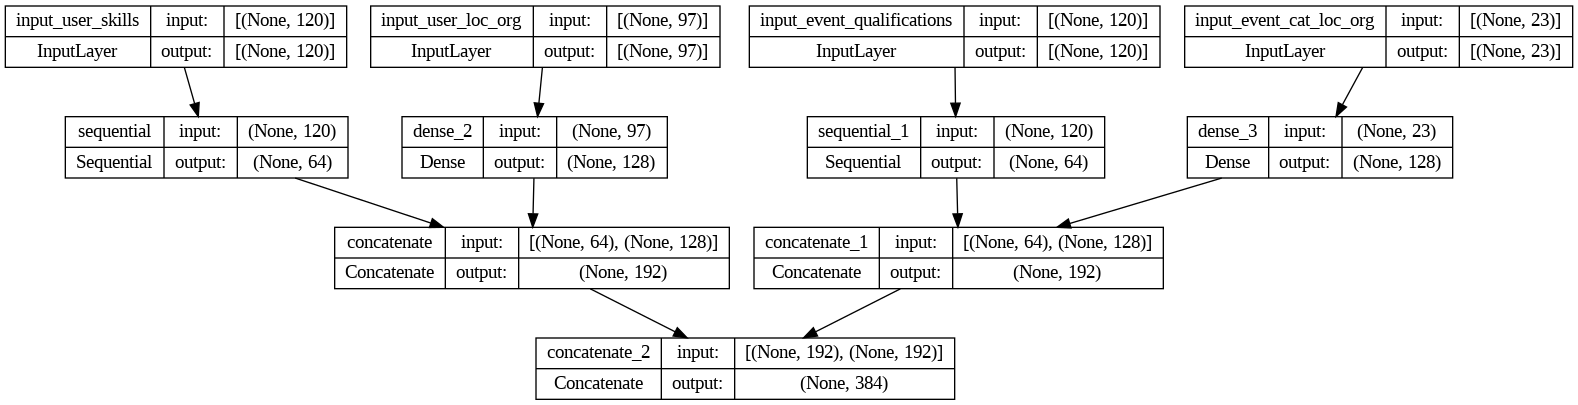

In [ ]:
from tensorflow.keras.utils import plot_model

# Membuat visualisasi model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


# TF JS

In [ ]:
saved_model_path = "./my_model.h5"


model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalle

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-12-11 06:01:42.458486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 06:01:42.458529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 06:01:42.459812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 06:01:43.445970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip output_model.zip *.bin model.json my_model.h5

updating: group1-shard1of2.bin (deflated 8%)
updating: group1-shard2of2.bin (deflated 8%)
updating: model.json (deflated 87%)
  adding: my_model.h5 (deflated 25%)


In [ ]:
# model.save('./saved_model')
#!pip install tensorflowjs
# !tensorflowjs_converter --input_format =tf_saved_model \
#                       --output_node_names='concatenate_2' \
#                       /saved_model \
#                        /output


# Convert To TF Lite

In [ ]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)


# GIST Code
```
This to make predict, but not use bobot to category
# Make predictions for the user
user_predictions = model.predict(user_input)

# Extract event IDs from the test set
event_ids = event_test['Event_id'].values

# Flatten user_predictions and event_ids
user_predictions_flat = user_predictions.flatten()
event_ids_flat = event_ids[:user_predictions_flat.shape[0]]

user_predictions_flat.shape, event_ids_flat.shape


print("Length of event_ids:", len(event_ids))
print("Length of user_predictions:", len(user_predictions.flatten()))
print("Shape of user_predictions:", user_predictions.shape)
print("Number of unique event_ids:", len(event_test['Event_id'].unique()))


# Ambil informasi kategori dan kualifikasi dari dataset event_test
event_info_selected = event_test[event_test['Event_id'].isin(event_ids_flat)][['Event_id', 'Category', 'Qualifications']]

# Gabungkan hasil prediksi dan informasi event
results_df = pd.DataFrame({
    'Event_id': event_ids_flat,
    'Interest_Score': user_predictions_flat
})

# Gabungkan dengan informasi kategori dan kualifikasi
results_df = pd.merge(results_df, event_info_selected, on='Event_id')

# Sort events based on predicted interest scores in descending order
recommendations = results_df.sort_values(by='Interest_Score', ascending=False)

# Display the top N recommendations
top_n_recommendations = 5
top_recommendations = recommendations.head(top_n_recommendations)

print(f"Top {top_n_recommendations} recommendations for the user:")
# print(top_recommendations[['Event_id', 'Category', 'Qualifications', 'Interest_Score']])
top_recommendations






print("Shape of user_predictions before flatten:", user_predictions.shape)
print("Length of event_ids:", len(event_ids))

# Flatten user_predictions
user_predictions_flat = user_predictions.flatten()

print("Shape of user_predictions after flatten:", user_predictions_flat.shape)
print("Length of event_ids after adjustment:", len(event_ids[:user_predictions_flat.shape[0]]))

```




Trying use 2 condition skill=qualification and category=type of organization
```

results_df['User_Skills'] = user_test.iloc[user_index]['Skills']
results_df['Event_Qualifications'] = event_test.iloc[user_index]['Qualifications']

results_df['Skill_Qualification_Match'] = results_df.apply(lambda row: 1 if row['User_Skills'] in row['Event_Qualifications'] else 0, axis=1)

results_df['Category_Organization_Match'] = np.where(results_df['Category'] == results_df['User_Organization_Type'], 1, 0)

results_df['Interest_Score_Adjusted'] = np.where(results_df['Skill_Qualification_Match'] == 1,
                                                 results_df['Interest_Score'] * 1.1,
                                                 results_df['Interest_Score'])

```



## Testing hanya memiliki user model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

# Load Event dataset
event_data = pd.read_csv("./events_dataset.csv",usecols=['Event_id','Category','Location','Qualifications'])
event_df = pd.DataFrame(event_data,)

# Load User dataset
user_data = pd.read_csv("./users_data_interest.csv",usecols=['Volunteer Name','Skills','Location','Type of Organization','Interest'])
user_df = pd.DataFrame(user_data)

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

# Split event and user data into training and testing sets
event_train, event_test = train_test_split(event_df, test_size=0.2, random_state=42)
user_train, user_test = train_test_split(user_df, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(user_df['Interest'], test_size=0.2, random_state=42)

# Tokenizer Train and Test Qualifications
tokenizer_qualification = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_qualification.fit_on_texts(event_train['Qualifications'])

qualification_seq = tokenizer_qualification.texts_to_sequences(event_train['Qualifications'])
qualification_pad = pad_sequences(qualification_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

qualification_seq_test = tokenizer_qualification.texts_to_sequences(event_test['Qualifications'])
qualification_pad_test = pad_sequences(qualification_seq_test, maxlen=max_length, padding=padding_type, truncating= trunc_type)

# Tokenizer Train and Test Skill
tokenizer_skill = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_skill.fit_on_texts(user_train['Skills'])

skill_seq = tokenizer_skill.texts_to_sequences(user_train['Skills'])
skill_pad = pad_sequences(skill_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

skill_seq_test = tokenizer_skill.texts_to_sequences(user_test['Skills'])
skill_pad_test = pad_sequences(skill_seq_test, maxlen=max_length, padding=padding_type, truncating= trunc_type)

# One hot encoding Event
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
event_cat_loc_org_encoded_train = encoder.fit_transform(event_train[['Category', 'Location']])
event_cat_loc_org_encoded_test = encoder.transform(event_test[['Category', 'Location']])

# One hot encoding user
user_loc_org_encoded_train = encoder.fit_transform(user_train[['Location', 'Type of Organization']])
user_loc_org_encoded_test = encoder.transform(user_test[['Location', 'Type of Organization']])

# Build user model
user_NN = tf.keras.models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, name='user_embedding')  # output layer for user model
])

# Inputs for user
input_user_skills = Input(shape=(max_length,), name='input_user_skills')
input_user_loc_org = Input(shape=(user_loc_org_encoded_train.shape[1],), name='input_user_loc_org')

# Call user model
vu_skills = user_NN(input_user_skills)
vu_loc_org = Dense(128, activation='relu')(input_user_loc_org)
vu = Concatenate()([vu_skills, vu_loc_org])

# Specify the inputs and outputs of the model
model = Model([input_user_skills, input_user_loc_org], vu)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Define inputs and outputs for training
train_inputs = [skill_pad, user_loc_org_encoded_train]

model.fit(train_inputs, y_train, epochs=10)

test_inputs = [skill_pad_test, user_loc_org_encoded_test]
model.evaluate(test_inputs, y_test)

## using the user in the test set
user_index = 0
user_input = [
    skill_pad_test[user_index][None, ...],
    user_loc_org_encoded_test[user_index][None, ...],
]

# Buat prediksi dengan model Anda
user_predictions = model.predict(user_input)

# Ubah prediksi menjadi DataFrame
predictions_df = pd.DataFrame(user_predictions.flatten(), columns=['Interest_Score'])

# Gabungkan prediksi dengan data acara
results_df = pd.concat([event_test.reset_index(drop=True), predictions_df], axis=1)

# add nama pengguna dan 'Type of Organization' ke DataFrame hasil
results_df['User_Name'] = user_test.iloc[user_index]['Volunteer Name']
results_df['User_Organization_Type'] = user_test.iloc[user_index]['Type of Organization']
# kolom baru 'Interest_Score_Adjusted' yang memberikan bobot lebih tinggi
# untuk acara yang 'Category'-nya cocok dengan 'Type of Organization' pengguna
results_df['Interest_Score_Adjusted'] = np.where(results_df['Category'] == results_df['User_Organization_Type'],
                                                 results_df['Interest_Score'] * 1.1,
                                                 results_df['Interest_Score'])

# Urutkan acara berdasarkan 'Interest_Score_Adjusted' dalam urutan menurun
results_df = results_df.sort_values(by='Interest_Score', ascending=False)

# Tampilkan 5 rekomendasi tertinggi
top_5_recommendations = results_df
top_5_recommendations.head()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_user_skills (InputLa  [(None, 120)]                0         []                            
 yer)                                                                                             
                                                                                                  
 input_user_loc_org (InputL  [(None, 97)]                 0         []                            
 ayer)                                                                                            
                                                                                                  
 sequential_5 (Sequential)   (None, 64)                   531904    ['input_user_skills[0][0]']   
                                                                                            

1/1 [==============================] - 0s 112ms/step


,Event_id,Category,Location,Qualifications,Interest_Score,User_Name,User_Organization_Type,Interest_Score_Adjusted
128,E1462,Healthcare,Bali,"Healthcare, Special needs support, Elderly care",1.082571,Ethan Walker,Environmental,1.082571
136,E1593,Social,Solo,"Environmental education, Health education, Car...",1.068807,Ethan Walker,Environmental,1.068807
69,E2524,Pet and Animal Service,Indonesia,"Pet adoption support, Animal behavior modifica...",1.067592,Ethan Walker,Environmental,1.067592
94,E368,Youth Development,Tangerang,"Event planning, Volunteer management",1.061035,Ethan Walker,Environmental,1.061035
142,E533,IT,Yogyakarta,"Computer literacy, Photography",1.059255,Ethan Walker,Environmental,1.059255


# ===========================================

# Breakline
